In [25]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import datetime
import time

import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import pickle
import os
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [2]:
%matplotlib inline
sns.set_style('whitegrid')

In [3]:
path = Path('../data/facebook')
list(path.iterdir())

[PosixPath('../data/facebook/after_eda'),
 PosixPath('../data/facebook/fea_sample'),
 PosixPath('../data/facebook/test_y.csv'),
 PosixPath('../data/facebook/train.csv'),
 PosixPath('../data/facebook/train_woheader_sample.csv'),
 PosixPath('../data/facebook/train_y.csv')]

In [5]:
df_final_train = read_hdf(path/'fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf(path/'fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [6]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [7]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [8]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'], axis=1, inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'], axis=1, inplace=True)


Estimators =  10 Train Score 0.9063252121775113 test Score 0.8745605278006858
Estimators =  50 Train Score 0.9205725512208812 test Score 0.9125653355634538
Estimators =  100 Train Score 0.9238690848446947 test Score 0.9141199714153599
Estimators =  250 Train Score 0.9239789348046863 test Score 0.9188007232664732
Estimators =  450 Train Score 0.9237190618658074 test Score 0.9161507685828595


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

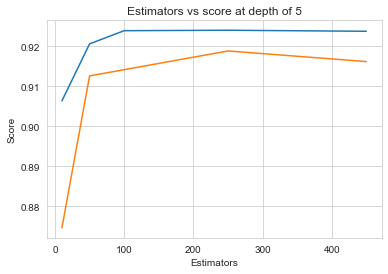

In [9]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=5, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=52, min_samples_split=120,
             min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    
    clf.fit(df_final_train, y_train)
    train_f1 = f1_score(y_train, clf.predict(df_final_train))
    test_f1 = f1_score(y_test, clf.predict(df_final_test))
    train_scores.append(train_f1)
    test_scores.append(test_f1)
    print('Estimators = ',i,'Train Score',train_f1,'test Score',test_f1)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')
    

Depth =  3 Train Score 0.8916120853581238 test Score 0.8687934859875491
Depth =  9 Train Score 0.9572226298198419 test Score 0.9222953031452904
Depth =  11 Train Score 0.9623451340902863 test Score 0.9252318758281279
Depth =  15 Train Score 0.9634267621927706 test Score 0.9231288356496615
Depth =  20 Train Score 0.9631629153051491 test Score 0.9235051024711141
Depth =  35 Train Score 0.9634333127085721 test Score 0.9235601652753184
Depth =  50 Train Score 0.9634333127085721 test Score 0.9235601652753184
Depth =  70 Train Score 0.9634333127085721 test Score 0.9235601652753184
Depth =  130 Train Score 0.9634333127085721 test Score 0.9235601652753184


Text(0.5, 1.0, 'Depth vs score at depth of 5 at estimators = 115')

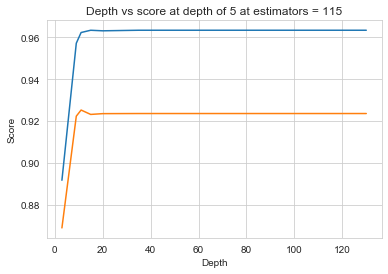

In [12]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=i, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=52, min_samples_split=120,
             min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    
    clf.fit(df_final_train, y_train)
    train_f1 = f1_score(y_train, clf.predict(df_final_train))
    test_f1 = f1_score(y_test, clf.predict(df_final_test))
    train_scores.append(train_f1)
    test_scores.append(test_f1)
    print('Depth = ',i,'Train Score',train_f1,'test Score',test_f1)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
    

In [17]:
params_dict = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)


rf_random = RandomizedSearchCV(clf, param_distributions=params_dict,
                               n_iter=5,cv=10,scoring='f1',random_state=25,
                               return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96225043 0.96215493 0.96057081 0.96194015 0.96330005]
mean train scores [0.96294922 0.96266735 0.96115674 0.96263457 0.96430539]


In [19]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=14, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=28, min_samples_split=111,
                       min_weight_fraction_leaf=0.0, n_estimators=121,
                       n_jobs=-1, oob_score=False, random_state=25, verbose=0,
                       warm_start=False)


In [20]:
clf = rf_random.best_estimator_

In [21]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [22]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9652533106548414
Test f1 score 0.9241678239279553


In [55]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    P = C / C.sum(axis=0)
    R = C.T / C.sum(axis=1).T
    
    sns.set_style(None)
    plt.figure(figsize=(15,5))
    labels = [0,1]
    cmap = sns.light_palette('blue')
    plt.subplot(1, 3, 1)
    annot_kws = {"ha": 'center',"va": 'center'}
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels, annot_kws=annot_kws)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(P, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    sns.heatmap(R, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


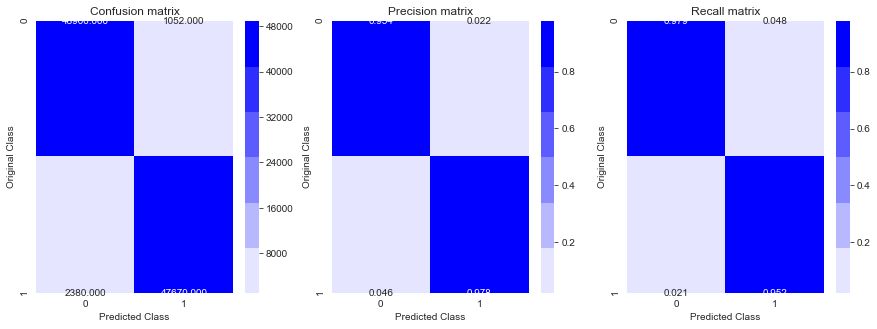

Test confusion_matrix


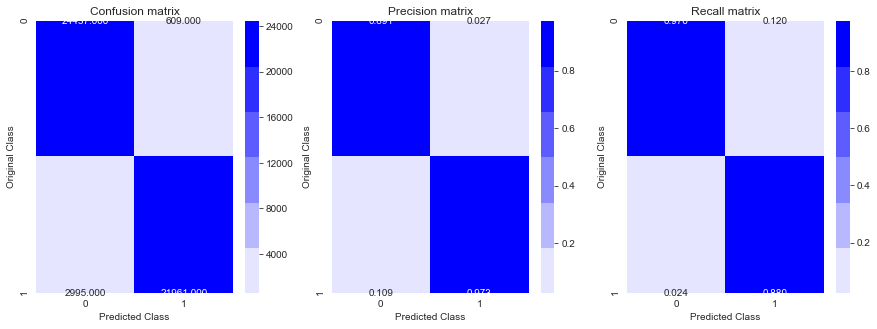

In [56]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

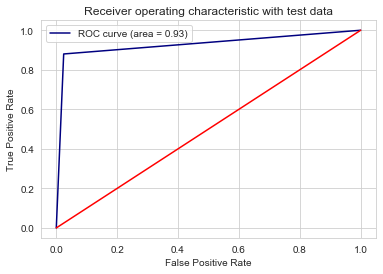

In [52]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.plot([0, 1], [0, 1], color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()


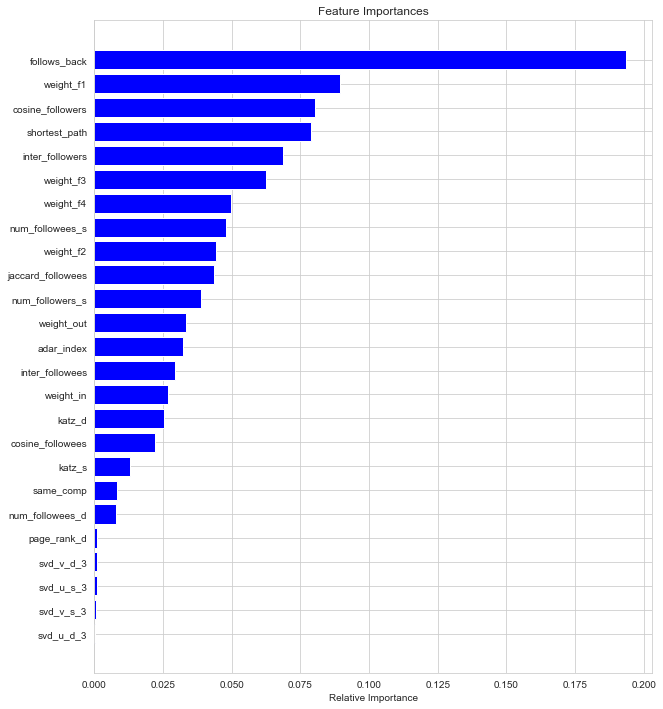

In [57]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
